In [1]:
import math
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn import preprocessing
from Training import model, utils, dataset, train
from sklearn.model_selection import train_test_split


import keras.backend as K

In [2]:
def check_acc(y_hat,y,margin=0.05):
    a_err = (np.abs(y_hat - y)) # get normalized error 
    err = np.divide(a_err, y, out=a_err, where=y!=0)
    assert(err.shape == y.shape)
    num_correct = 0
    for row in err:
        num_in_row = len(np.where(row < margin)[0]) # margin * 100 because 
        if num_in_row == len(row):
            num_correct += 1

    num_samples = y.shape[0]
    correct_idx = np.where(err < margin)
    num_part_correct = len(correct_idx[0])
    num_part_samples = y.shape[0] * y.shape[1]
    print(f"Correct = {num_correct} / {num_samples}")
    return (num_correct/num_samples)
from matplotlib.patches import Ellipse
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip
def multivariate_gaussian_nll(ypreds, ytrue, var):
    
    diag = torch.exp(var[:,:2]) # convert log-scale var to
    n = ypreds.shape[1] #number of parameters ie number of means (2 gain and bandwidth)
    B = ypreds.shape[0] #Batch size
    
    z = torch.zeros(B)
    o = torch.ones(B)
    D = torch.stack((diag[:,0],z,z,diag[:,1]),dim=1).reshape(B,2,2) # form Diagnol matrix D for LDLT
    L = torch.stack((o,z,var[:,2],o),dim=1).reshape(B,2,2) # form L matrix 
    LT = torch.stack((o,var[:,2],z,o),dim=1).reshape(B,2,2) # form LT matrix (transpose of L)

    sigma = L @ D @ LT   # form sigma inv from LDLT decomp
    ximu =(ytrue-ypreds).reshape(B,2,1)  #true- minus 
    ximuT =(ytrue-ypreds).reshape(B,1,2) # true- minus  transpose

    loss = 0.5*torch.mean(ximuT@sigma@ximu + ((n/2)*(-torch.sum(var[:,:2],axis=1).reshape(B,1))))
    return loss
def formCovMatrix(var):
    diag = np.exp(var[:2])
    z = np.zeros(2)
    o = np.ones(2)
    D = np.array([diag[0],0,0,diag[1]]).reshape(2,2)
    L = np.array([1,0,var[2],1]).reshape(2,2)
    LT = np.array([1,var[2],0,1]).reshape(2,2)
    sigma = L @ D @ LT
    return np.linalg.pinv(sigma)

In [3]:
data = utils.parseGainAndBWCsv2("Data/BW-3000.csv").astype(float)

In [4]:
print(data[0])

[6.200e+02 2.880e-06 3.775e+00 8.280e+10]


In [5]:
data = preprocessing.MinMaxScaler((0,1)).fit_transform(data)
X = data[:,:2]
Y = data[:,2:]

In [6]:
test_model = model.DistModelBatchNorm(2,2)

In [7]:
optimizer = optim.Adagrad(test_model.parameters(),lr=3e-4)
loss_fn = nn.L1Loss()

dataset1 = dataset.CircuitSynthesisGainAndBandwidthManually(Y, X)
train_dataset, val_dataset = utils.splitDataset(dataset1, 0.9)
    
train_data = DataLoader(train_dataset,batch_size = 500)
validation_data = DataLoader(val_dataset, batch_size = 500)

In [8]:
epochs = 1000
loss_list, val_loss_list = train.trainAbsoluteModel(test_model, train_data, loss_fn, optimizer, num_epochs=epochs, print_every=10, validation_data=validation_data)

t = 10, loss = 0.0876, val loss = 0.3319
t = 20, loss = 0.0670, val loss = 0.0895
t = 30, loss = 0.0578, val loss = 0.0879
t = 40, loss = 0.0508, val loss = 0.0841
t = 50, loss = 0.0492, val loss = 0.0833
t = 60, loss = 0.0464, val loss = 0.0796
t = 70, loss = 0.0446, val loss = 0.0735
t = 80, loss = 0.0431, val loss = 0.0672
t = 90, loss = 0.0414, val loss = 0.0727
t = 100, loss = 0.0405, val loss = 0.0812
t = 110, loss = 0.0414, val loss = 0.0539
t = 120, loss = 0.0391, val loss = 0.0711
t = 130, loss = 0.0392, val loss = 0.0650
t = 140, loss = 0.0382, val loss = 0.0561
t = 150, loss = 0.0363, val loss = 0.0627
t = 160, loss = 0.0361, val loss = 0.0659
t = 170, loss = 0.0344, val loss = 0.0557
t = 180, loss = 0.0349, val loss = 0.0568
t = 190, loss = 0.0337, val loss = 0.0685
t = 200, loss = 0.0337, val loss = 0.0587
t = 210, loss = 0.0339, val loss = 0.0679
t = 220, loss = 0.0335, val loss = 0.0650
t = 230, loss = 0.0328, val loss = 0.0719
t = 240, loss = 0.0320, val loss = 0.0641
t

In [9]:
test_y = []
test_x = []
for i in val_dataset:
    test_y.append(list(i[0]))
    test_x.append(list(i[1]))
test_y = np.array(test_y)
test_x = np.array(test_x)

In [10]:
test_model.eval()
x_preds = test_model(torch.Tensor(test_y))
#print(x_preds)
mock_simulator = tf.keras.models.load_model('mock_simulator2.0')
#mock_simulator = mockSimulator

final_preds = []
for i in range(x_preds.shape[0]):
    means = x_preds.detach().numpy()[i,:2].T
    w,r = means
    y_hat = mock_simulator(means.reshape(1,2)) # feed back through simulator to get evaluated performance
    final_preds.append(y_hat)
final_preds = np.array(final_preds).reshape(-1,2)
    


In [11]:
check_acc(test_y,final_preds,margin=.05)

Correct = 74 / 303


0.24422442244224424

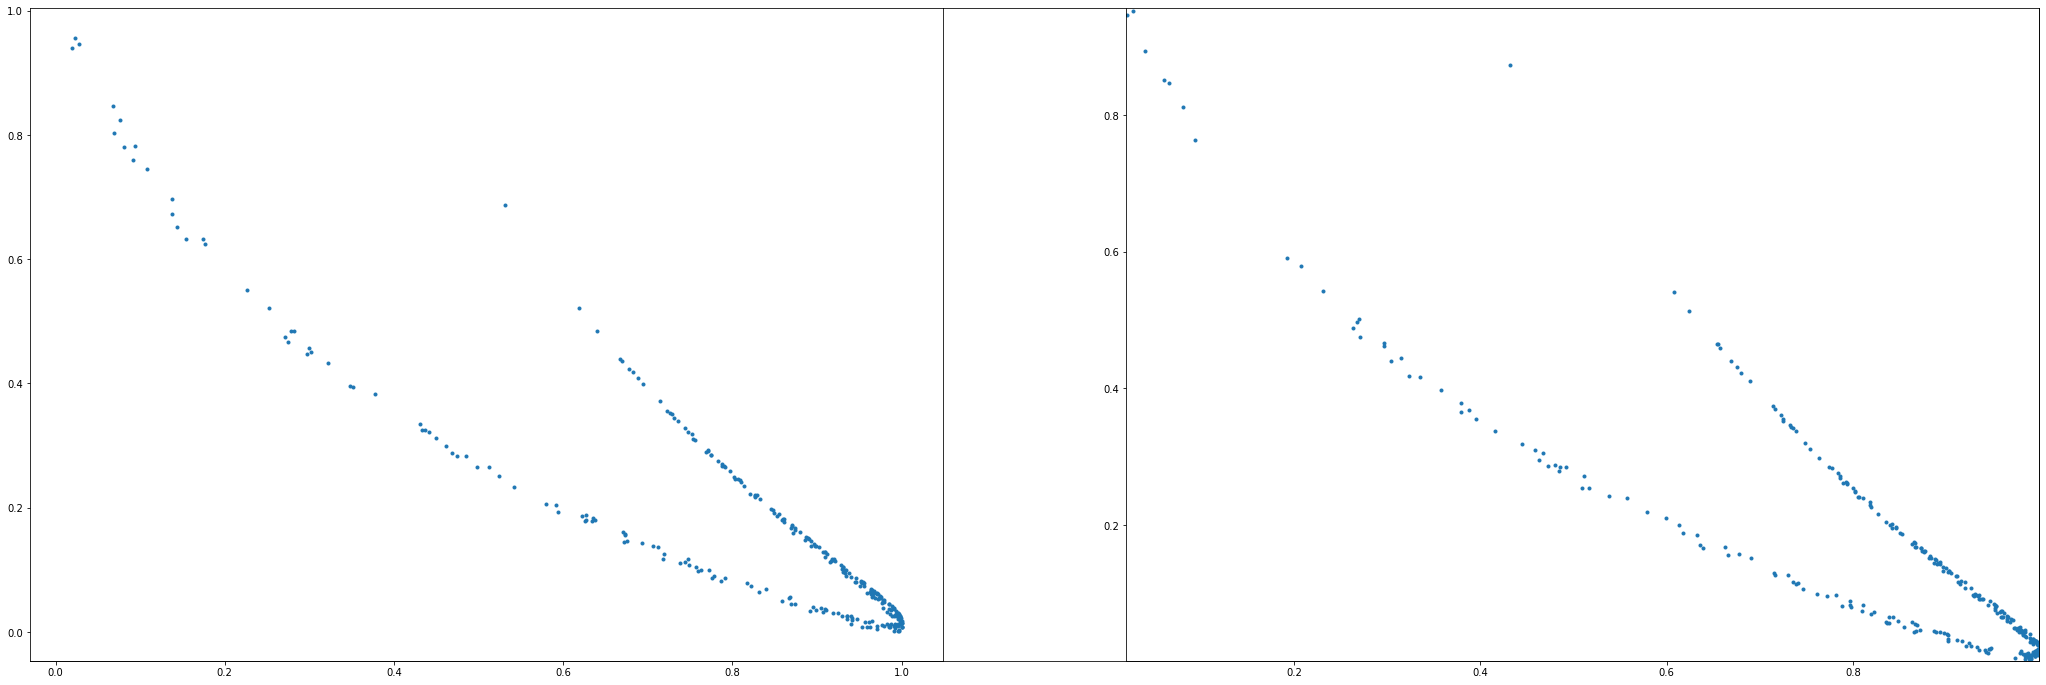

In [12]:
fig, axes = plt.subplots(figsize=(36, 12))
axes.get_xaxis().set_visible(False) # remove erroreas graph axis
axes.get_yaxis().set_visible(False)


xlim = [test_y[:,0].min(),test_y[:,0].max()]
ylim = [test_y[:,1].min(),test_y[:,1].max()]


ax = fig.add_subplot(121)
plt.plot(test_y[:,0],test_y[:,1], ".")
ax = fig.add_subplot(122)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.plot(final_preds[:,0],final_preds[:,1], ".")

plt.show()

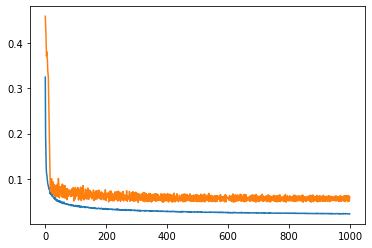

In [13]:
plt.plot(loss_list)
plt.plot(val_loss_list)

In [14]:
final_preds = []
for i in range(x_preds.shape[0]):
    means = test_x[i,:2].T
    w,r = means
    y_hat = mock_simulator(means.reshape(1,2)) # feed back through simulator to get evaluated performance
    final_preds.append(y_hat)
final_preds = np.array(final_preds).reshape(-1,2)
check_acc(test_y,final_preds,margin=.05)

Correct = 271 / 303


0.8943894389438944

In [15]:
test_gaussian_model = model.DistModelBatchNorm(2,5)

In [16]:
optimizer_gaussian = optim.Adagrad(test_gaussian_model.parameters(),lr=0.001)
loss_gaussian_fn = multivariate_gaussian_nll

In [17]:
epochs = 1000
loss_list, val_loss_list = train.trainProbModel(test_gaussian_model, train_data, loss_gaussian_fn, optimizer_gaussian, num_epochs=epochs, print_every=10, validation_data=validation_data)

t = 10, loss = -1.5291, val loss = -1.5520
t = 20, loss = -2.0792, val loss = -2.1440
t = 30, loss = -2.5320, val loss = -2.5330
t = 40, loss = -2.8883, val loss = -2.9494
t = 50, loss = -3.1895, val loss = -3.2030
t = 60, loss = -3.3807, val loss = -3.4043
t = 70, loss = -3.7329, val loss = -3.7269
t = 80, loss = -3.8532, val loss = -3.8167
t = 90, loss = -4.0721, val loss = -4.1627
t = 100, loss = -4.2235, val loss = -4.3298
t = 110, loss = -4.3585, val loss = -4.3958
t = 120, loss = -4.4835, val loss = -4.5559
t = 130, loss = -4.6943, val loss = -4.7245
t = 140, loss = -4.8944, val loss = -4.9020
t = 150, loss = -4.9600, val loss = -4.9468
t = 160, loss = -4.7157, val loss = -4.8025
t = 170, loss = -5.1043, val loss = -5.3441
t = 180, loss = -5.2569, val loss = -5.3724
t = 190, loss = -5.3424, val loss = -5.3576
t = 200, loss = -5.1429, val loss = -5.4138
t = 210, loss = -5.6700, val loss = -5.7854
t = 220, loss = -5.5757, val loss = -5.7322
t = 230, loss = -5.6023, val loss = -5.73

In [18]:
test_gaussian_model.eval()
x_preds = test_gaussian_model(torch.Tensor(test_y))

mock_simulator = tf.keras.models.load_model('mock_simulator2.0')

final_g_preds = []
for i in range(x_preds.shape[0]):
    means = x_preds.detach().numpy()[i,:2].T
    w,r = means
    y_hat = mock_simulator(means.reshape(1,2)) # feed back through simulator to get evaluated performance
    final_g_preds.append(y_hat)
final_g_preds = np.array(final_g_preds).reshape(-1,2)
    

# for i,d in enumerate(final_preds):
#     print(Y[i],d)
check_acc(test_y,final_g_preds,margin=.05)

Correct = 187 / 303


0.6171617161716172

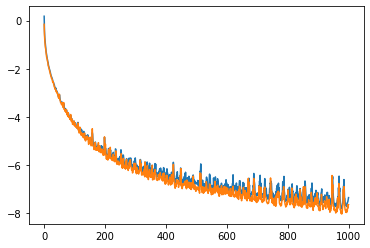

In [19]:
plt.plot(loss_list)
plt.plot(val_loss_list)